In [240]:
import os
import re
import timeit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from bs4 import BeautifulSoup
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [241]:
data_folder = "data"
submissions_folder = os.path.join(data_folder, "submissions") 

train_file = os.path.join(data_folder, "train.csv")
test_file = os.path.join(data_folder, "test.csv")

In [242]:
train_df = pd.read_csv(train_file)

In [326]:
test_df = pd.read_csv(test_file)

In [243]:
df = train_df.drop(columns=["id", "keyword", "location"])

In [244]:
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [245]:
df.loc[:, "text"] = df.text.astype("string")
df.loc[:, "original"] = df.text

#### Check len of each tweet

In [246]:
df.loc[:, "pre_clean_len"] = df.text.str.len()

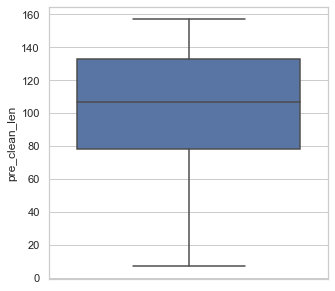

In [247]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=df, y="pre_clean_len", ax=ax)

### Data Cleaning
#### HTML decoding

In [248]:
def html_cleaning(text):
    # Clean html encoding
    text = BeautifulSoup(text, 'lxml').get_text()
    return text

df.loc[:, "text"] = df.text.apply(html_cleaning)

In [249]:
df.iloc[62].original

'Rene Ablaze &amp; Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013  https://t.co/7MLMsUzV1Z'

In [250]:
df.iloc[62].text

'Rene Ablaze & Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013  https://t.co/7MLMsUzV1Z'

#### Remove mentions (@username)

<b>Useful new Pandas features</b>

In [251]:
mentions_reg = re.compile(r'@[A-Za-z0-9]+')
df.loc[:, "text"] = df.text.str.replace(mentions_reg, '')

In [252]:
df.iloc[36].original

"@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season."

In [253]:
df.iloc[36].text

" #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season."

#### Remove urls

In [254]:
df.text[31]

' Wholesale Markets ablaze http://t.co/lHYXEOHY6C'

In [255]:
links_reg = re.compile(r'https?://[A-Za-z0-9./]+')
df.loc[:, "text"] = df.text.str.replace(links_reg, '')

In [256]:
df.iloc[62].original

'Rene Ablaze &amp; Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013  https://t.co/7MLMsUzV1Z'

In [257]:
df.iloc[62].text

'Rene Ablaze & Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013  '

#### Convert to lowercase

In [258]:
df.loc[:, "text"] = df.text.str.lower()

#### Replace english negations

In [259]:
negations_dic = {"isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
                 "haven't": "have not","hasn't": "has not", "hadn't": "had not","won't": "will not",
                 "wouldn't": "would not","don't": "do not", "doesn't": "does not","didn't": "did not",
                 "can't": "can not","couldn't": "could not","shouldn't": "should not","mightn't": "might not",
                 "mustn't": "must not"}

neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
df.loc[:, "text"] = df.text.apply(lambda text: neg_pattern.sub(lambda x: negations_dic[x.group()], text))

In [260]:
df.iloc[343].original

"@RohnertParkDPS You're on stage now! Right under the lights! Isn't it funny?! Where do you get the goofballs with which you staff your PD?"

In [261]:
df.iloc[343].text

" you're on stage now! right under the lights! is not it funny?! where do you get the goofballs with which you staff your pd?"

#### Get only letters

In [262]:
letters_reg = re.compile(r'[^a-zA-Z]')
df.loc[:, "text"] = df.text.str.replace(letters_reg, ' ')

#### Remove extra blank spaces

In [263]:
space_re = re.compile(' +')
df.loc[:, "text"] = df.text.str.replace(space_re, ' ')

In [264]:
df.iloc[343].original

"@RohnertParkDPS You're on stage now! Right under the lights! Isn't it funny?! Where do you get the goofballs with which you staff your PD?"

In [265]:
df.iloc[343].text

' you re on stage now right under the lights is not it funny where do you get the goofballs with which you staff your pd '

In [272]:
# Stemming
porter = PorterStemmer()
train_df.loc[:, "text"] = train_df.text.apply(lambda text: " ".join([porter.stem(word) for word in text.split(" ")]))

### Data Visualitzation

### Boxplot to compare pre cleaned and cleaned lenghts

In [273]:
df.loc[:, "clean_len"] = df.text.str.len()

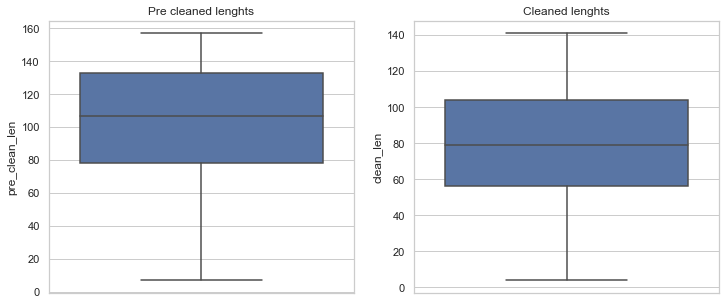

In [274]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.boxplot(data=df, y="pre_clean_len", ax=ax1)
sns.boxplot(data=df, y="clean_len", ax=ax2)

_ = ax1.set_title("Pre cleaned lenghts")
_ = ax2.set_title("Cleaned lenghts")

In [275]:
stop_words = stopwords.words('english')
def generate_word_cloud(texts, title, stop_words=stop_words):
    words = [word.lower() for text in texts for word in text if word not in stop_words]
    frequences_dict = pd.Series(words).value_counts().to_dict()
    
    wordcloud = WordCloud().generate_from_frequencies(frequences_dict)

    fig = plt.subplots(figsize=(16, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=32)
    plt.show()

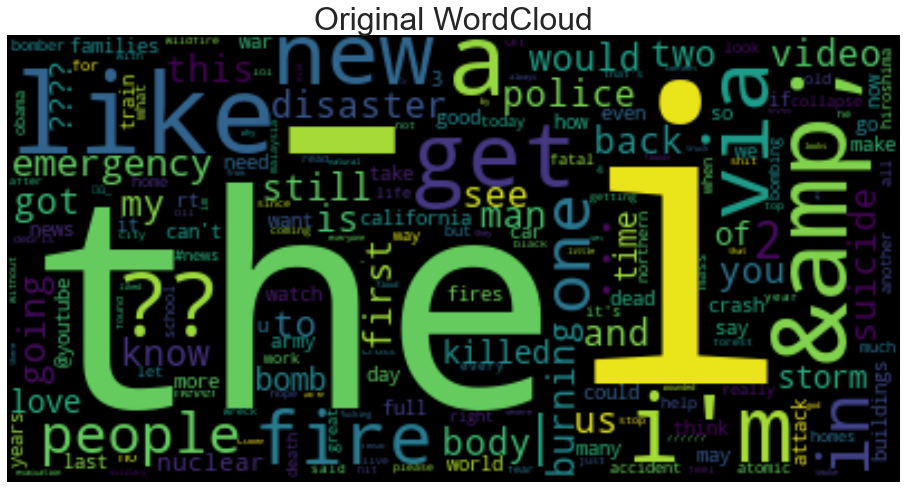

In [276]:
splited = df.original.str.split(" ").tolist()
generate_word_cloud(splited, "Original WordCloud")

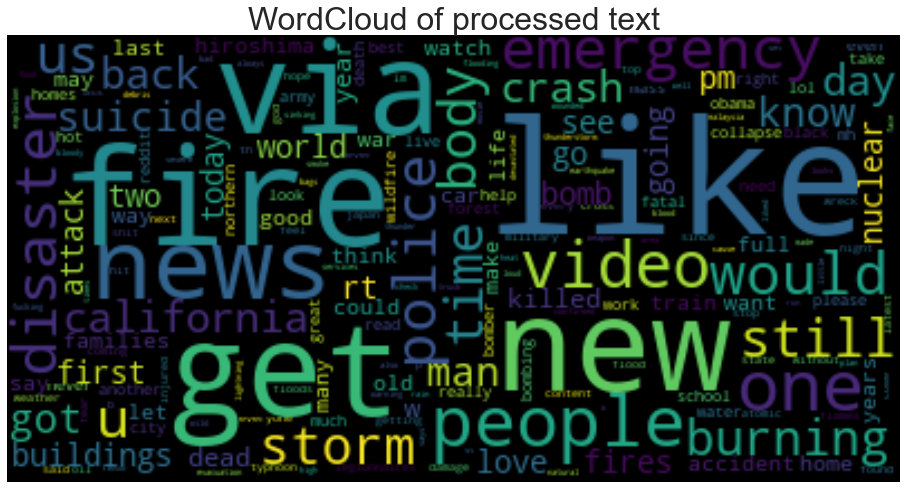

In [277]:
splited = df.text.str.split(" ").tolist()
generate_word_cloud(splited, "WordCloud of processed text")

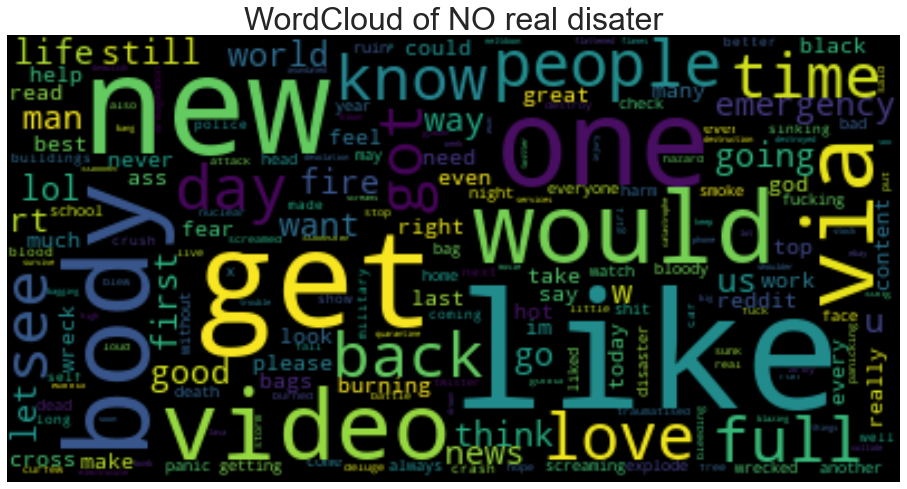

In [278]:
splited = df[df.target == 0].text.str.split(" ").tolist()
generate_word_cloud(splited, "WordCloud of NO real disater")

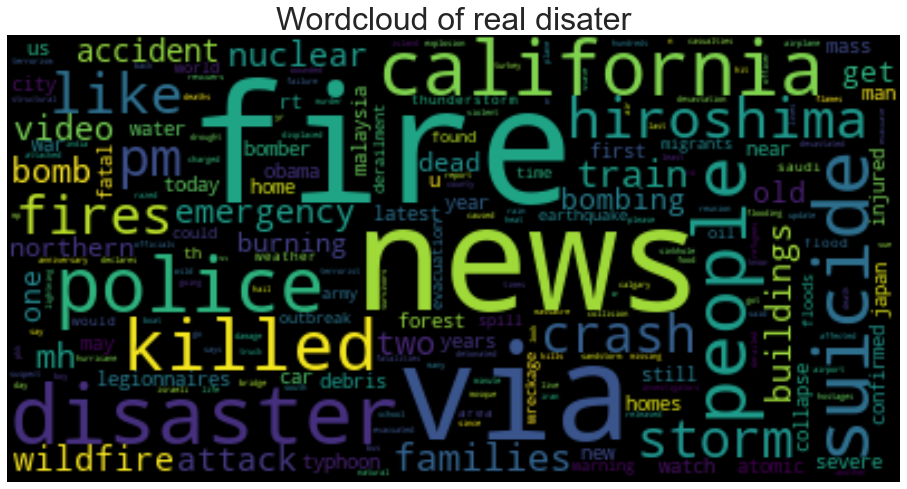

In [279]:
splited = df[df.target == 1].text.str.split(" ").tolist()
generate_word_cloud(splited, "Wordcloud of real disater")

In [280]:
count_vec = CountVectorizer(stop_words="english")
count_vec.fit(df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [281]:
print(f"Vocabulary size {len(count_vec.get_feature_names())}")

Vocabulary size 13920


#### Get term frequency (TF) for each class

In [282]:
neg_doc_matrix = count_vec.transform(df[df.target == 0].text)
pos_doc_matrix = count_vec.transform(df[df.target == 1].text)

neg_tf = np.sum(neg_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg, pos], columns=count_vec.get_feature_names()).transpose()
term_freq_df.loc[:, "Total Documents"] = term_freq_df[0] + term_freq_df[1]
term_freq_df.columns = ["No real disaster", "Real disaster", "Total"]

term_freq_df.sort_values(by="Total", ascending=False, inplace=True)

term_freq_df.head()

,No real disaster,Real disaster,Total
like,254,94,348
just,234,89,323
new,171,56,227
news,61,149,210
people,94,105,199


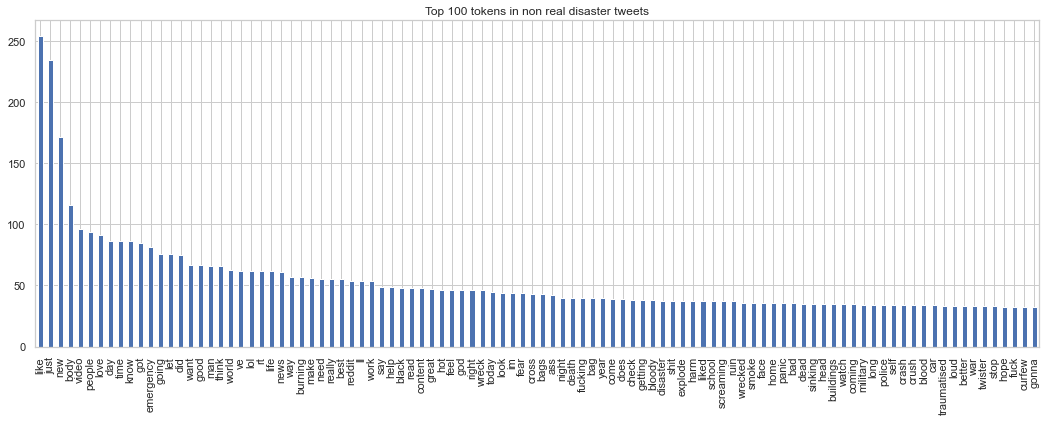

In [283]:
fig, ax = plt.subplots(figsize=(18, 6))

top_100_non_disaster = term_freq_df.sort_values(by="No real disaster", ascending=False)[:100]["No real disaster"]
top_100_non_disaster.plot(kind="bar", ax=ax, title="Top 100 tokens in non real disaster tweets")

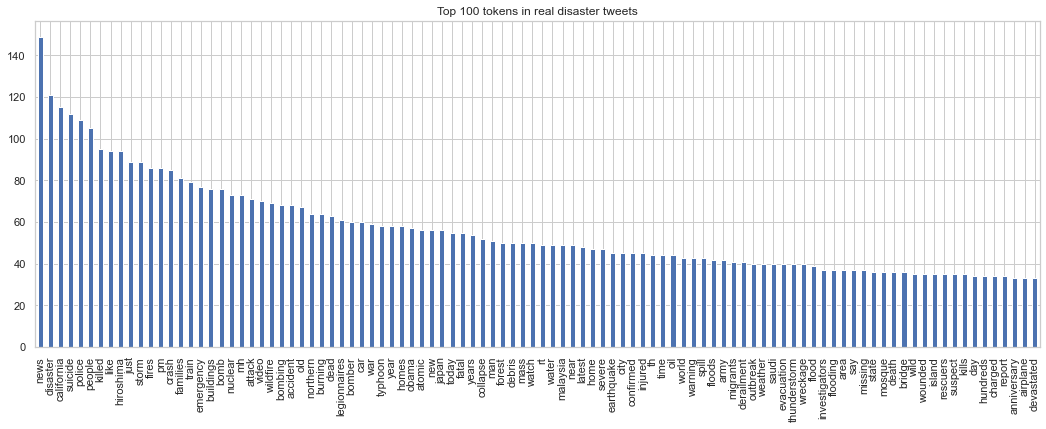

In [284]:
fig, ax = plt.subplots(figsize=(18, 6))

top_100_disaster = term_freq_df.sort_values(by="Real disaster", ascending=False)[:100]["Real disaster"]
top_100_disaster.plot(kind="bar", ax=ax, title="Top 100 tokens in real disaster tweets")

### Train with different models and features

Pipelines for feature extraction

In [285]:
def create_pipeline(stop_words="english", max_features=None, tf_idf=True, ngram_range=(1, 1), classifier=None, verbose=1):
    count_vec = CountVectorizer(ngram_range=ngram_range)
    
    if stop_words:
        count_vec.set_params(**{"stop_words": "english"})
    if max_features:
        count_vec.set_params(**{"max_features": max_features})
        
    pipeline_elements = [("bow", count_vec)]
    
    if tf_idf:
        pipeline_elements.append(("tfidf", TfidfTransformer()))
    if classifier:
        pipeline_elements.append(("classifier", classifier))
        
    return Pipeline(pipeline_elements, verbose=verbose)

def train_and_predict(model, name, x_train, y_train, x_test, y_test, target_names, logs=True):       
    start = timeit.default_timer()
    model.fit(x_train, y_train)
    stop = timeit.default_timer()
    
    training_time = stop - start
    
    y_pred = model.predict(x_test)
    
    accuracy = accuracy_score(y_pred, y_test)
    
    if logs:
        print(f"\nTraining {name}")
        print(f"Training time: {training_time}\nPredictions...")
        print(classification_report(y_pred, y_test, target_names=target_names))
        print(f"Confusion matrix:\n{confusion_matrix(y_pred, y_test)}")
        print(f"\nAccuracy: {accuracy}")
        print("-"*20)
    
    return training_time, accuracy

In [286]:
x_train, x_test, y_train, y_test = train_test_split(train_df["text"], train_df["target"], test_size=0.20, random_state=90)

In [287]:
n_features = np.arange(1000, 40000, 1500)

# Only count vectorized ngram 1, 1
pipelines_only_count_vec = []
for n_feature in n_features:
    pipe = create_pipeline(tf_idf=False, max_features=n_feature, verbose=0)
    pipelines_only_count_vec.append(({"features": n_feature, "ngrams": 1}, pipe))
    
# Only count vectorized ngram 1, 2
for n_feature in n_features:
    pipe = create_pipeline(tf_idf=False, max_features=n_feature, ngram_range=(1, 2), verbose=0)
    pipelines_only_count_vec.append(({"features": n_feature, "ngrams": 2}, pipe))
    
# Only count vectorized ngram 1, 3
for n_feature in n_features:
    pipe = create_pipeline(tf_idf=False, max_features=n_feature, ngram_range=(1, 3), verbose=0)
    pipelines_only_count_vec.append(({"features": n_feature, "ngrams": 3}, pipe))

Text(0.5, 1.0, 'Only Count vectorizer and different ngrams')

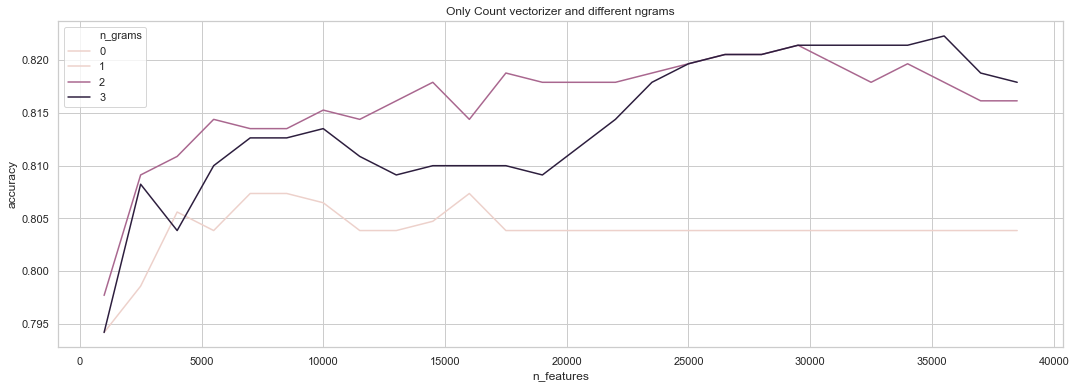

In [330]:
results = []
for conf, pipe in pipelines_only_count_vec:
    x_train_i = pipe.fit_transform(x_train)
    x_test_i = pipe.transform(x_test)
     
    t, acc = train_and_predict(MultinomialNB(), "Naivy bayes", x_train_i, y_train, x_test_i, y_test, 
                               ["No real disaster", "Real disaster"], logs=False)
    
    params = pipe["bow"].get_params()
    
    results.append({"time": t, "accuracy": acc, "n_features": params["max_features"],
                    "n_grams": f"{params['ngram_range'][1]}"})
    
results_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(18, 6))

sns.lineplot(data=results_df, x="n_features", y="accuracy", hue="n_grams", ax=ax)
ax.set_title("Only Count vectorizer and different ngrams")

In [331]:
# ngram 1, 1
pipelines_tfidf = []
for n_feature in n_features:
    pipe = create_pipeline(max_features=n_feature, verbose=0)
    pipelines_tfidf.append(({"features": n_feature, "ngrams": 1}, pipe))
    
# ngram 1, 2
for n_feature in n_features:
    pipe = create_pipeline(max_features=n_feature, ngram_range=(1, 2), verbose=0)
    pipelines_tfidf.append(({"features": n_feature, "ngrams": 2}, pipe))
    
# ngram 1, 3
for n_feature in n_features:
    pipe = create_pipeline(max_features=n_feature, ngram_range=(1, 3), verbose=0)
    pipelines_tfidf.append(({"features": n_feature, "ngrams": 3}, pipe))

Text(0.5, 1.0, 'Only Count vectorizer and different ngrams')

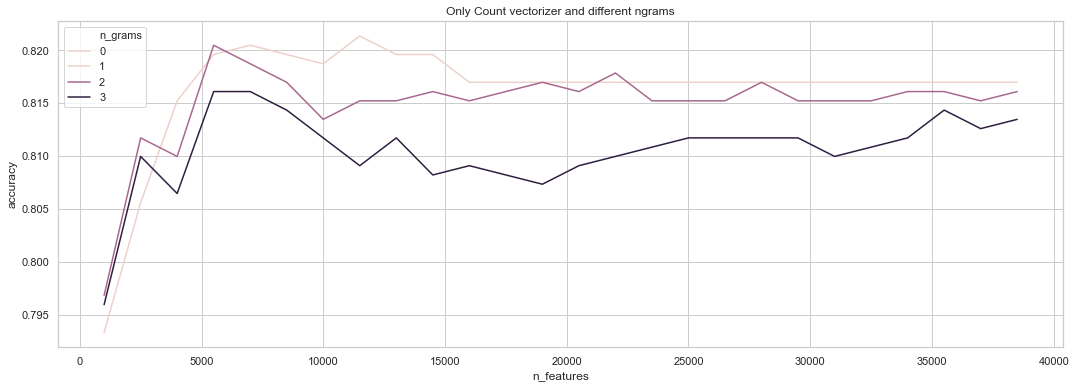

In [332]:
results = []
for conf, pipe in pipelines_tfidf:
    x_train_i = pipe.fit_transform(x_train)
    x_test_i = pipe.transform(x_test)
     
    t, acc = train_and_predict(MultinomialNB(), "Naivy bayes", x_train_i, y_train, x_test_i, y_test, 
                               ["No real disaster", "Real disaster"], logs=False)
    
    params = pipe["bow"].get_params()
    
    results.append({"time": t, "accuracy": acc, "n_features": params["max_features"],
                    "n_grams": f"{params['ngram_range'][1]}"})
    
results_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(18, 6))

sns.lineplot(data=results_df, x="n_features", y="accuracy", hue="n_grams", ax=ax)
ax.set_title("Different ngrams")

In [364]:
pipelines = []

pipeline_bayes = Pipeline([
    ("bow", CountVectorizer(stop_words="english", ngram_range=(1, 2), max_features=8000)),
    ("tfidf", TfidfTransformer()),
    ("classifier", MultinomialNB())
])

pipelines.append(("Naivy Bayes", pipeline_bayes))

pipeline_logistic = Pipeline([
    ("bow", CountVectorizer(stop_words="english", ngram_range=(1, 2), max_features=8000)),
    ("tfidf", TfidfTransformer()),
    ("classifier", LogisticRegression())
])

pipelines.append(("Logisitic Regression", pipeline_logistic))

pipeline_svm = Pipeline([
    ("bow", CountVectorizer(stop_words="english", ngram_range=(1, 2), max_features=8000)),
    ("tfidf", TfidfTransformer()),
    ("classifier", SVC())
])

pipelines.append(("SVM", pipeline_svm))

In [365]:
x_train, x_test, y_train, y_test = train_test_split(train_df["text"], train_df["target"], test_size=0.15)

In [366]:
for name, pipe in pipelines:
    train_and_predict_pipeline(pipe, name, x_train, y_train, x_test, y_test, ["No real disaster", "Real disaster"])


Training Naivy Bayes ...
Done!
Training time: 0.284554574998765
Making predictions...
                  precision    recall  f1-score   support

No real disaster       0.94      0.77      0.85       799
   Real disaster       0.62      0.88      0.73       343

        accuracy                           0.80      1142
       macro avg       0.78      0.83      0.79      1142
    weighted avg       0.84      0.80      0.81      1142

Confusion matrix:
[[618 181]
 [ 42 301]]

Accuracy: 0.8047285464098074
--------------------

Training Logisitic Regression ...
Done!
Training time: 0.3772923479991732
Making predictions...
                  precision    recall  f1-score   support

No real disaster       0.90      0.79      0.84       752
   Real disaster       0.68      0.84      0.75       390

        accuracy                           0.81      1142
       macro avg       0.79      0.81      0.80      1142
    weighted avg       0.83      0.81      0.81      1142

Confusion matrix:
[[59

In [336]:
pipeline_bayes.fit(train_df.text, train_df.target)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=12000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [337]:
y_pred = pipeline_bayes.predict(test_df["text"])

#### But, with Sklearn, we can compute this in really easy way

In [ ]:
vectorizer_pipeline = Pipeline([
    ("bow", CountVectorizer()),
    ("tfidf", TfidfTransformer())
])
     
r = vectorizer_pipeline.fit_transform(df.text)

In [338]:
def create_submission_file(predictions, ids, path, filename="submission.csv"):
    submission_data = {
        "id": ids,
        "target": predictions
    }

    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(os.path.join(path, filename), index=False)
    
    print("Good luck!")

In [339]:
create_submission_file(y_pred, test_df.id, submissions_folder)

Good luck!
